In [5]:
#import pertpy as pt
import scanpy as sc
import numpy as np

import random
import torch
import sklearn
import os
def set_seed(seed: int):
    # Set Python random seed
    random.seed(seed)

    # Set NumPy random seed
    np.random.seed(seed)

    # Set PyTorch random seed
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)  # If using multi-GPU.

        # Ensure deterministic behavior in PyTorch (can slow down computations)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

    # Set sklearn random seed
    sklearn.utils.check_random_state(seed)

    # Set environment variable for reproducibility
    os.environ['PYTHONHASHSEED'] = str(seed)

set_seed(123)

import warnings
warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", category=FutureWarning)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

AnnData object with n_obs × n_vars = 1378211 × 2000
    obs: 'assay_ontology_term_id', 'cell_type_ontology_term_id', 'disease_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'organism_ontology_term_id', 'sex_ontology_term_id', 'tissue_ontology_term_id', 'is_primary_data', 'Neurotypical reference', 'Class', 'Subclass', 'Supertype', 'Age at death', 'Years of education', 'Cognitive status', 'ADNC', 'Braak stage', 'Thal phase', 'CERAD score', 'APOE4 status', 'Lewy body disease pathology', 'LATE-NC stage', 'Microinfarct pathology', 'Specimen ID', 'donor_id', 'PMI', 'Number of UMIs', 'Genes detected', 'Fraction mitochrondrial UMIs', 'suspension_type', 'development_stage_ontology_term_id', 'Continuous Pseudo-progression Score', 'tissue_type', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage', 'observation_joinid', 'batch_backup', 'batch', 'condition_backup', 'condition', 'group', 'leiden', 'leiden1', 'leiden2', 'batch_c

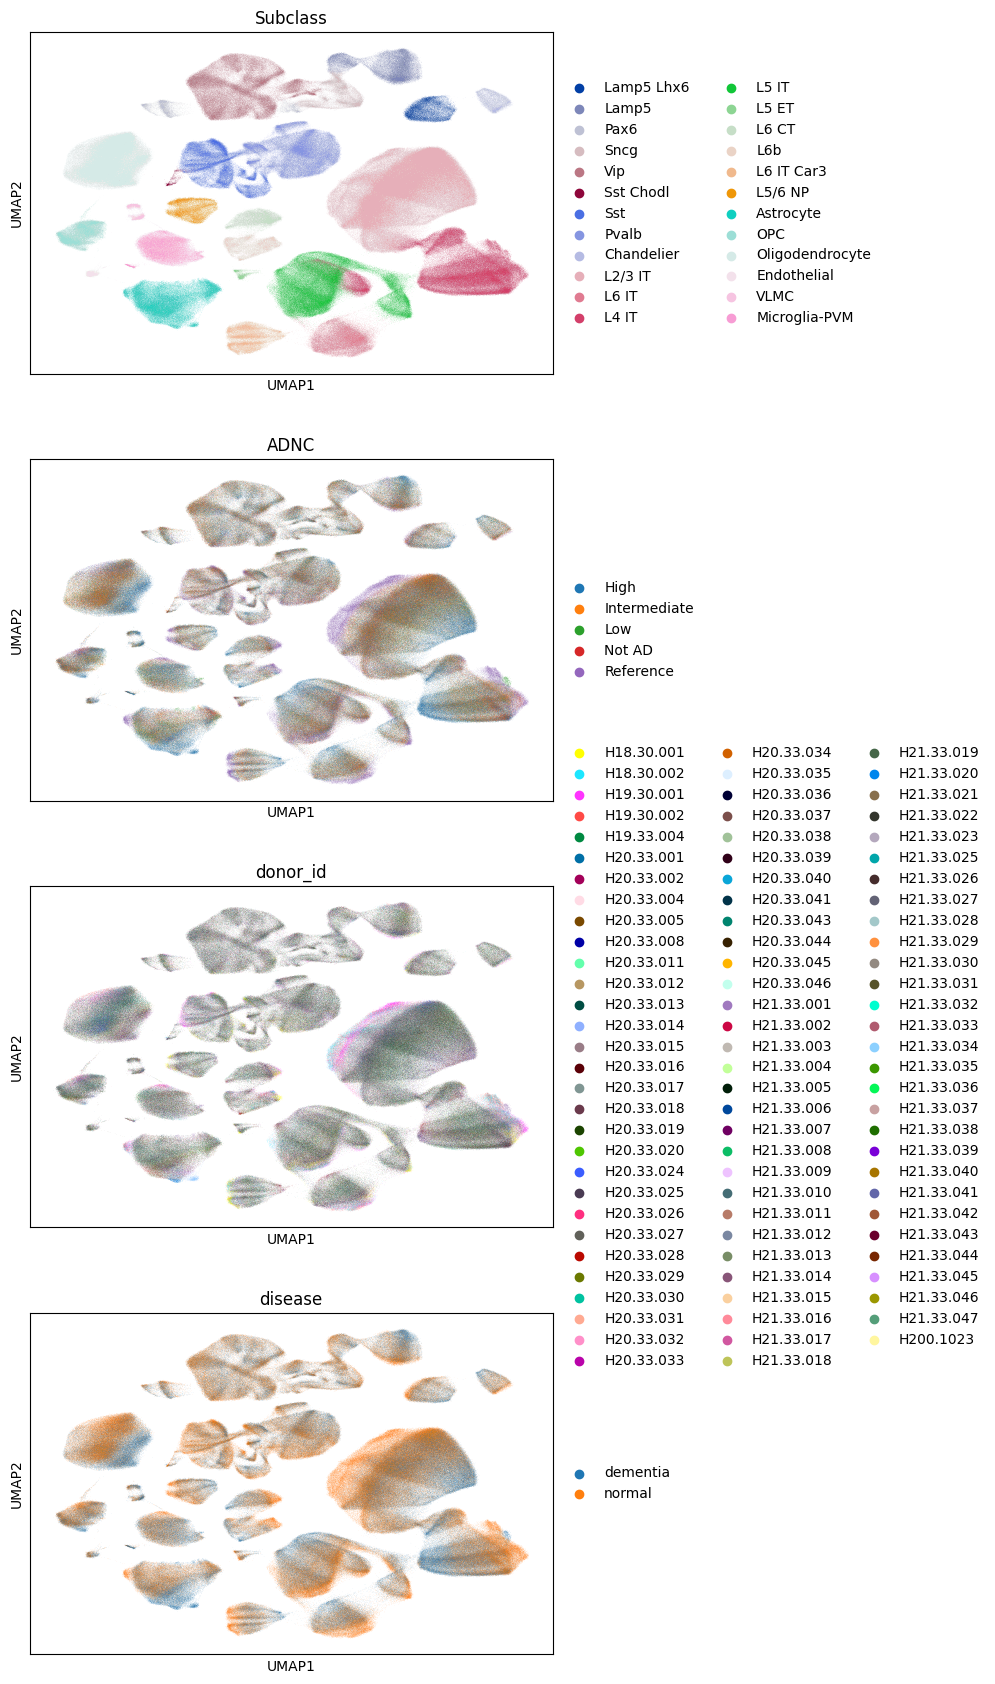

In [16]:
adata=sc.read_h5ad("./AD/preprocessed.h5ad")#sc.read_h5ad("./data/AD.h5ad")
print(adata)
adata.raw = None
sc.pl.umap(adata,color=["Subclass","ADNC","donor_id","disease"],ncols=1)

In [8]:
from ndreamer import NDreamer

model = NDreamer(adata, condition_key="disease", contorl_name='normal', num_hvg=2000, require_batch=True,
                            batch_key='donor_id',
                            resolution_low=0.5, resolution_high=7, cluster_method="Leiden", embedding_dim=512,
                            codebooks=[1024 for i in range(32)],
                            codebook_dim=8, encoder_hidden=[1024, 512], decoder_hidden=[512, 1024], z_dim=256,
                            cos_loss_scaler=20, random_seed=123, batch_size=2048, epoches=10, lr=1e-3,
                            triplet_margin=5,independent_loss_scaler=1000, save_pth="./AD/",
                            developer_test_mode=True,
                            library_size_normalize_adata=False,
                            save_preprocessed_adata_path="./AD/preprocessed.h5ad",
                            KL_scaler=5e-3, reconstruct_scaler=1, triplet_scaler=5, num_triplets_per_label=15,
                            tau=0.01, commitment_loss_scaler=1, cluster_correlation_scaler=50,reset_threshold=1/1024,
                            reset_interval=30,try_identify_cb_specific_subtypes=False,
                            local_neighborhood_loss_scaler=1,local_neighbor_sigma=1,
                            try_identify_perturb_escaped_cell=False,n_neighbors=20,
                            local_neighbor_across_cluster_scaler=20)

Using device: <class 'torch.cuda.device'>
1
Remaining number of cells: 1378211
Too few epoches (steps, if rigorously speaking). Changing epoch to 57 to adjust for number of cells
Require batch: True
Preprocessing time: 1.40599 seconds


In [13]:
import torch.nn as nn

number_batches=len(np.unique(adata.obs['donor_id']))
print(number_batches)
num_batches=[number_batches]
model.DL_model.VQ_VAE.batch_embedding=nn.ModuleList([
            nn.Embedding(num_batches[i], 512) for i in range(len(num_batches))
        ])

model.DL_model.load_state_dict(torch.load(os.path.join(model.save_pth, 'ndreamer' + '.pth'), map_location=device))
with torch.no_grad():
    model.get_modifier_space()
model.decompose_true_expression_batch_effect_all(nearest_neighbor=1,bandwidth=1)
model.Estmiate_ITE_all(nearest_neighbor=1,bandwidth=1)

89


KeyboardInterrupt: 

# No batch effect

In [14]:
adata1=sc.read_h5ad("./AD_nobatch/preprocessed.h5ad")

In [15]:
from ndreamer import NDreamer

model = NDreamer(adata1, condition_key="disease", contorl_name='normal', num_hvg=2000, require_batch=False,
                            batch_key=None,
                            resolution_low=0.5, resolution_high=7, cluster_method="Leiden", embedding_dim=512,
                            codebooks=[1024 for i in range(32)],
                            codebook_dim=8, encoder_hidden=[1024, 512], decoder_hidden=[512, 1024], z_dim=256,
                            cos_loss_scaler=20, random_seed=123, batch_size=2048, epoches=10, lr=1e-3,
                            triplet_margin=5,independent_loss_scaler=1000, save_pth="./AD_nobatch/",
                            developer_test_mode=True,
                            library_size_normalize_adata=False,
                            save_preprocessed_adata_path="./AD_nobatch/preprocessed.h5ad",
                            KL_scaler=5e-3, reconstruct_scaler=1, triplet_scaler=5, num_triplets_per_label=15,
                            tau=0.01, commitment_loss_scaler=1, cluster_correlation_scaler=50,reset_threshold=1/1024,
                            reset_interval=30,try_identify_cb_specific_subtypes=False,
                            local_neighborhood_loss_scaler=1,local_neighbor_sigma=1,
                            try_identify_perturb_escaped_cell=False,n_neighbors=20,
                            local_neighbor_across_cluster_scaler=20)

#model.train_model()
model.DL_model.load_state_dict(torch.load(os.path.join(model.save_pth, 'ndreamer' + '.pth'), map_location=device))
print("Finish loading the trained model")
with torch.no_grad():
    model.get_modifier_space()
model.decompose_true_expression_batch_effect_all(nearest_neighbor=1,bandwidth=1)
model.Estmiate_ITE_all(nearest_neighbor=1,bandwidth=1)

Using device: <class 'torch.cuda.device'>
1
Remaining number of cells: 1378211
Too few epoches (steps, if rigorously speaking). Changing epoch to 2548 to adjust for number of cells
Require batch: False
Preprocessing time: 1.30851 seconds
Finish loading the trained model


KeyboardInterrupt: 